<a href="https://colab.research.google.com/github/T0B1K/BrailleGloveStatistics/blob/main/study1/experiment/study1_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Constants

In [1]:
import seaborn as sns
import re
import pandas as pd

pastel_colors = sns.color_palette("pastel", 3)

# Define the order for the conditions and map them to the pastel colors
condition_order = ["Stroke", "Tap", "Vibration"]
condition_palette = {
    "Stroke": pastel_colors[0],  # First color in the pastel palette
    "Tap": pastel_colors[1],     # Second color in the pastel palette
    "Vibration": pastel_colors[2]  # Third color in the pastel palette
}
sns.set(style="whitegrid")

# Example usage
participantDataOrder = [
    (1,"STV.txt", "STV"), (2,"SVT.txt", "SVT"), (3,"TVS.txt", "TVS"), (4,"TSV.txt", "TSV"),
    (5,"VTS.txt", "VTS"), (6,"VST.txt", "VST"), (7,"STV2.txt", "STV"), (8,"SVT2.txt", "SVT"),
    (9,"TVS2.txt", "TVS"), (10,"VTS2.txt", "VTS"), (11,"TSV2.txt", "TSV"), (12,"VST2.txt", "VST")
]

# Predefined mappings
braille_character = {
    't': '⠞ (T)', 'h': '⠓ (H)', 'e': '⠑ (E)', 'o': '⠕ (O)', 'l': '⠇ (L)', 'd': '⠙ (D)',
    'p': '⠏ (P)', 'u': '⠥ (U)', 'b': '⠃ (B)', 'the': '⠞⠓⠑ (THE)', 'old': '⠕⠇⠙ (OLD)', 'pub': '⠏⠥⠃ (PUB)'
}

keyset = ["s", "d", "f", "j", "k", "l"]

numbers_encoding = {char: f'({i+1}) [{char.upper()}]' for i, char in enumerate('fdsjkl')}

setMapper = {key: set(value) for key, value in {
    "t": ["d", "s", "j", "k"], "h": ["f", "d", "k"], "e": ["f", "k"], "o": ["f", "s", "k"],
    "l": ["f", "d", "s"], "d": ["f", "j", "k"], "p": ["f", "d", "s", "j"], "u": ["f", "s", "l"], "b": ["f", "d"]
}.items()}

## Load Data

In [2]:


def getPandasDataFrameFromText(file_name: str) -> pd.DataFrame:
    """
    Reads a text file and extracts structured data into a Pandas DataFrame.

    The function looks for patterns in the text that match the format:
    "Test <Test Name> Submitted Value <Submitted Value> Test Time (ms) <Test Time>"

    Args:
        file_name (str): The name of the text file to read.

    Returns:
        pd.DataFrame: A DataFrame containing columns "Test", "Submitted Value", and "Test Time (ms)".
                      If the file is not found, an empty DataFrame is returned.
    """
    try:
        with open(file_name, "r") as file:
            text = file.read()
    except FileNotFoundError:
        print("File not found.")
        return pd.DataFrame()

    pattern = re.compile(r"Test\s+(\S+)\s+Submitted Value\s+(.+?)\s+Test Time \(ms\)\s+(\d+)", re.DOTALL)
    return pd.DataFrame([
        {"Test": test, "Submitted Value": submitted_value.strip(), "Test Time (ms)": int(test_time)}
        for test, submitted_value, test_time in pattern.findall(text)
    ])

def jaccard_coefficient(set1:dict, set2:dict) -> float:
    """
    Calculate the Jaccard coefficient between two sets.

    The Jaccard coefficient is defined as the size of the intersection
    divided by the size of the union of the two sets.

    Args:
        set1 (set): The first set.
        set2 (set): The second set.

    Returns:
        float: The Jaccard coefficient, a value between 0 and 1.
    """
    return len(set1.intersection(set2)) / len(set1.union(set2))

def deciderFunction(df:pd.DataFrame, sequence:str) -> int:
    """
    Determines an index based on the given value using predefined conditions.

    Args:
        value (str): A string representing a key to look up in the conditions dictionary.
        sequence (str): A string from which the function extracts a character based on the found index.

    Returns:
        int: The corresponding character from the sequence at the found index, or None if the value is not in conditions.
    """
    conditions = {'t': 0, 'h': 0, 'e': 0, 'the': 0, 'o': 1, 'l': 1, 'd': 1, 'old': 1, 'p': 2, 'u': 2, 'b': 2, 'pub': 2}
    return sequence[conditions.get(df, -1)] if df in conditions else None

def splitDataset(participantDataOrder) -> tuple:
    """
    Splits a dataset into two parts based on test conditions and calculates the Jaccard coefficient.

    Args:
        participantDataOrder (list of tuples): A list where each tuple contains:
            - Participant ID (str)
            - File name (str) containing the test data
            - Sequence (str) for condition determination

    Returns:
        tuple: A tuple containing two DataFrames:
            - dataframe_no_tests: Data without specific test words, with Jaccard coefficient calculated.
            - dataframe_tests: Data containing only specific test words ('the', 'old', 'pub').
    """
    dataframe_list = []

    for tuples in participantDataOrder:
        dataframe = getPandasDataFrameFromText(tuples[1])
        dataframe['ParticipantID'] = tuples[0]
        dataframe['Condition'] = dataframe["Test"].apply(lambda x: deciderFunction(x, tuples[2]))
        dataframe_list.append(dataframe)

    dataframe = pd.concat(dataframe_list, ignore_index=True)

    # Split dataset into two parts based on the 'Test' value
    dataframe_no_tests = dataframe[~dataframe['Test'].isin(['test', 'the', 'old', 'pub'])]
    dataframe_no_tests.loc[:, "jaccard_coefficient"] = dataframe_no_tests.apply(
      lambda row: jaccard_coefficient(set(row["Submitted Value"]), setMapper[row["Test"]]), axis=1)
    dataframe_no_tests = dataframe_no_tests.loc[dataframe_no_tests.groupby(['Condition', 'Test', 'ParticipantID'])['jaccard_coefficient'].idxmax()]
    dataframe_tests = dataframe[dataframe['Test'].isin(['the', 'old', 'pub'])]

    return dataframe_no_tests, dataframe_tests

def filterDataFrame(value: str, df, column: str) -> pd.DataFrame:
    """
    Filters a DataFrame based on a specified column value.

    Args:
        value (str): The value to filter by.
        df (pd.DataFrame): The DataFrame to filter.
        column (str): The column name to apply the filter on.

    Returns:
        pd.DataFrame: A new DataFrame containing only the rows where the specified column matches the given value.
    """
    return df[df[column] == value]

def jaccard_word_score(word: str, test_word: str) -> float:
    """
    Computes the Jaccard word score by comparing each word's character set to a mapped test word.

    Args:
        word (str): The input word or phrase to compare.
        test_word (str): The reference test word or phrase.

    Returns:
        float: The average Jaccard coefficient over all words in the phrase, or 0 if lengths do not match.
    """
    if len(test_word) != len(word.split()):
        return 0
    return sum(jaccard_coefficient(set(w), setMapper[t]) for w, t in zip(word.split(), test_word)) / len(test_word)

def getMaxJaccardDataFrame(dataframe_tests, condition:str) -> pd.DataFrame:
    """
    Retrieves the rows with the highest Jaccard word score for each participant and test under a specific condition.

    Args:
        dataframe_tests (pd.DataFrame): The input DataFrame containing test results.
        condition (str): The condition to filter the DataFrame by.

    Returns:
        pd.DataFrame: A DataFrame containing the rows with the highest Jaccard word score for each participant and test.
    """
    dataframe_filtered = dataframe_tests[(dataframe_tests['Test'].isin(['the', 'old', 'pub'])) & (dataframe_tests['Condition'] == condition)]
    dataframe_copy = dataframe_filtered.copy()
    dataframe_copy["jaccard_word_score"] = dataframe_copy.apply(
        lambda row: jaccard_word_score(row["Submitted Value"], row["Test"]), axis=1
    )

    return dataframe_copy.loc[dataframe_copy.groupby(['ParticipantID', 'Test'])['jaccard_word_score'].idxmax()]



In [3]:
dataframe_no_tests, dataframe_tests = splitDataset(participantDataOrder)

dataframe_tests_V_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "V")
dataframe_tests_S_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "S")
dataframe_tests_T_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "T")

dataframe_no_tests_s = filterDataFrame("S", dataframe_no_tests, "Condition")
dataframe_no_tests_t = filterDataFrame("T", dataframe_no_tests, "Condition")
dataframe_no_tests_v = filterDataFrame("V", dataframe_no_tests, "Condition")

<ipython-input-2-2d4a49acafa8>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_no_tests.loc[:, "jaccard_coefficient"] = dataframe_no_tests.apply(


## Analyse Data

In [4]:

def get_TP(submitted_value:str, tested_character:str) -> float:
  """
    Computes the True Positives (TP) by counting common elements between submitted and ground truth sets.

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: The number of true positives.
    """
  return len(set(submitted_value) & setMapper[tested_character])

def get_FP(submitted_value:str, tested_character:str) -> float:
  """
    Computes the False Positives (FP) by counting surplus elements in the submitted set.

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: The number of false positives.
    """
  return len(set(submitted_value) - setMapper[tested_character])

def get_FN(submitted_value:str, tested_character:str) -> float:
  """
    Computes the False Negatives (FN) by counting missing elements in the submitted set.

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: The number of false negatives.
    """
  return len(setMapper[tested_character] - set(submitted_value))

def precision(submitted_value:str, tested_character:str) -> float:
  """
    Computes precision as TP / (TP + FP).

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: Precision score.
    """
  return get_TP(submitted_value, tested_character) / (get_TP(submitted_value, tested_character) + get_FP(submitted_value, tested_character))

def recall(submitted_value:str, tested_character:str)-> float:
  """
    Computes recall as TP / (TP + FN).

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: Recall score.
    """
  return get_TP(submitted_value, tested_character) / (get_TP(submitted_value, tested_character) + get_FN(submitted_value, tested_character))

def f1_score(submitted_value:str, tested_character:str)-> float:
  """
    Computes the F1-score, which is the harmonic mean of precision and recall.

    Args:
        submitted_value (str): The submitted character value.
        tested_character (str): The ground truth character.

    Returns:
        float: F1-score.
    """
  prec = precision(submitted_value, tested_character)
  rec = recall(submitted_value, tested_character)
  divisor = prec + rec
  f1 = 0
  if divisor != 0:
    f1 = 2 * (prec * rec) / divisor
  return f1


def evaluateData(value:str, test:str, condition:str):
  """
  Computes various evaluation metrics for submitted values against test characters.

  Args:
      value (str): The submitted word or phrase.
      test (str): The reference test characters.
      condition (str): The condition under which the evaluation is performed.

  Returns:
      list: A list of tuples containing evaluation metrics.
  """
  return [
      (
          f1_score(submitted_value, tested_character),
          precision(submitted_value, tested_character),
          recall(submitted_value, tested_character),
          get_TP(submitted_value, tested_character),
          get_FP(submitted_value, tested_character),
          set(submitted_value),
          setMapper[tested_character],
          setMapper[tested_character] - set(submitted_value),
          set(submitted_value) - setMapper[tested_character],
          tested_character,
          condition,
          jaccard_coefficient(set(submitted_value), setMapper[tested_character])
      )
      for submitted_value, tested_character in zip(value.split(), test)
  ]


def evaluateDataFrames(dataframes):
    """
    Applies evaluateData to all provided DataFrames and aggregates results.

    Args:
        dataframes (list of pd.DataFrame): A list of DataFrames to evaluate.

    Returns:
        pd.DataFrame: A DataFrame containing aggregated evaluation metrics.
    """
    compareCharacters = []

    for df in dataframes:
        df.apply(lambda row: compareCharacters.extend(
            evaluateData(row["Submitted Value"], row["Test"], row["Condition"])
        ), axis=1)

    columns = [
        'F1', 'Precision', 'Recall', 'TP', 'FP', 'Submitted Value',
        'Ground Truth', 'Missed Character', 'Surplus Character',
        'Tested Character', 'Condition', 'Jaccard Score'
    ]

    return pd.DataFrame(compareCharacters, columns=columns)

In [5]:
data = [dataframe_tests_V_maxJaccard, dataframe_tests_S_maxJaccard, dataframe_tests_T_maxJaccard]
analysed_data = evaluateDataFrames(data)

## Test Compare

### Boxplot Code

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from scipy.stats import kruskal

def plot_boxplot_with_swarmplot(data:pd.DataFrame, score:str, test:str, i:int):
  """
  Plot the boxplot for a given test with a swarmplot on top.

  Parameters:
      data (pd.DataFrame): Data filtered for the specific test.
      score (str): The score column to plot.
      test (str): The test name for the title.
      i (int): The index of the subplot.
  """
  # Plot the boxplot
  sns.boxplot(
      x='Condition',
      y=score,
      data=data,
      showfliers=False,
      palette=condition_palette,
      order=condition_order,
      width=0.7,
      dodge=False,  # Keep all conditions in the same box plot
      medianprops={'color': '#6E6E6E', 'linewidth': 2},
      hue='Condition'
  )

  # Add swarmplot on top of the boxplot
  sns.swarmplot(
      x='Condition',
      y=score,
      data=data,
      color='black',  # 'k' stands for black, or you can customize the color
      alpha=0.6,  # Adjust transparency
      size=3,  # Adjust size of the points
      dodge=False  # Keep all points on top of each box
  )

  # Customize the plot for the current test
  plt.title(f"{braille_character[test]}", fontsize=12)
  plt.xlabel('Stimulus')
  if i == 0:
      plt.ylabel(score.replace('_', ' ').title())  # Add y-axis label for the first plot
  else:
      plt.ylabel('')  # Remove y-axis label for other plots
  # Set the y-axis range from 0 to 1
  plt.ylim(0, 1)


def perform_tests(test_data, test:str, score:str):
  """
    Perform statistical tests on the provided data for a specific test and score.

    Args:
        test_data (pd.DataFrame): The dataset containing the test results.
        test (str): The test name used for filtering the dataset.
        score (str): The score column to be analyzed for statistical tests.

    Returns:
        None: This function performs analysis and prints results directly.
    """
  print_medians(test_data, test, score)
  conditions_data = [test_data[test_data['Condition'] == condition][score].values for condition in test_data['Condition'].unique()]
  perform_levenes(conditions_data)
  kruskal_H, p_value_kruskal = perform_kruskal(conditions_data)
  calculate_eta_squared(kruskal_H, conditions_data)
  if p_value_kruskal < 0.05:
    perform_posttest(conditions_data)
  print("\n\n")

def perform_levenes(conditions_data:list):
  """
    Perform Levene's Test for equality of variances on the given conditions data.

    Args:
        conditions_data (list): A list of arrays where each array represents data for a condition.

    Returns:
        None: This function performs the test and prints the result.
    """
  stat_levene, p_value_levene = stats.levene(*conditions_data)
  print(f"Levene's Test: p-value = {p_value_levene}, stat: {stat_levene} -> Homogeneity of variances: {p_value_levene > 0.05}")

def perform_kruskal(condition_data:list) -> tuple:
  """
    Perform the Kruskal-Wallis H-test to assess if there are significant differences between conditions.

    Args:
        condition_data (list): A list of arrays where each array represents data for a condition.

    Returns:
        tuple: A tuple containing the Kruskal-Wallis statistic (H) and the p-value.
    """
  H, p_value_kruskal = stats.kruskal(*condition_data)
  print(f"Kruskal-Wallis: H-stat: {H:.4f}, p-value: {p_value_kruskal:.4f}\tSignificant difference between datasets: {p_value_kruskal < 0.05}")
  return H, p_value_kruskal

def calculate_eta_squared(kruskal_H, conditions_data):
  """
    Calculate the eta squared statistic to measure the effect size based on Kruskal-Wallis results.

    Args:
        kruskal_H (float): The Kruskal-Wallis statistic (H).
        conditions_data (list): A list of arrays representing the different conditions.

    Returns:
        None: This function prints the eta squared statistic.
    """
  N = sum(len(group) for group in conditions_data)  # Return H, p_value, k, N
  eta_squared = kruskal_H / (N - 1)
  print(f"eta_squared: {eta_squared}")

def perform_posttest(condition_data):
  """
    Perform a post-hoc test (Tukey's HSD) to compare all pairs of conditions if Kruskal-Wallis test is significant.

    Args:
        condition_data (list): A list of arrays representing the data for different conditions.

    Returns:
        None: This function prints the results of the Tukey's HSD test.
    """
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  all_data = np.concatenate(condition_data)
  labels = np.concatenate([[f"Condition {i+1}" for _ in range(len(d))] for i, d in enumerate(data)])
  tukey = pairwise_tukeyhsd(all_data, labels, alpha=0.05)
  print(tukey)

def print_medians(test_data:pd.DataFrame, test:str, score:float):
  """
    Print the medians of the given score for each condition in the test dataset.

    Args:
        test_data (pd.DataFrame): The dataset containing test results.
        test (str): The test name used for filtering the dataset.
        score (float): The score column for which the median is calculated.

    Returns:
        None: This function prints the median of each condition.
    """
  print(f"Medians for '{test}':")
  for condition in test_data['Condition'].unique():
      condition_data = test_data[test_data['Condition'] == condition]
      median = condition_data[score].median()
      print(f"  {condition}: {median}")

def print_boxplots_and_tests(data:pd.DataFrame, score:str="jaccard_coefficient", pdf_name:str = "", plotting_order:list = [], groupable:bool = True):
  """
  Generate boxplots and perform statistical tests for each condition, saving the result as a PDF.

  Args:
      data (pd.DataFrame): The dataset to be analyzed.
      score (str, optional): The score column to analyze (default is "jaccard_coefficient").
      pdf_name (str, optional): The name of the PDF file to save the plots (default is "").
      plotting_order (list, optional): The order in which tests should be plotted (default is []).
      groupable (bool, optional): Whether data should be grouped by test type (default is True).

  Returns:
      None: This function generates plots and saves them as a PDF.
  """
  pivot_df = data.copy()
  if groupable:
    pivot_df = data[['Test', 'Condition', 'ParticipantID', score]]
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)
  if len(plotting_order) == 3:
    plt.figure(figsize=(15, 4))
  else:
    plt.figure(figsize=(15, 10))


  for i, test in enumerate(plotting_order):
      if len(plotting_order) == 3:
        plt.subplot(1, 3, i + 1)
      else:
        plt.subplot(3, 3, i + 1)

      if groupable:
        test_data = pivot_df[pivot_df['Test'] == test]
      else:
        test_data = pivot_df[pivot_df['Tested Character'] == test]

      plot_boxplot_with_swarmplot(test_data, score, test, i)
      perform_tests(test_data, test, score)

  plt.tight_layout()
  plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')



### Boxplots for the Learning phase

<ipython-input-6-7e9d8ea100de>:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)


Medians for 't':
  Stroke: 0.575
  Tap: 0.4642857142857143
  Vibration: 0.6333333333333333
Levene's Test: p-value = 0.04162262443493394, stat: 4.620700382188248 -> Homogeneity of variances: False
Kruskal-Wallis: H-stat: 1.9406, p-value: 0.3790	Significant difference between datasets: False
eta_squared: 0.1764184397163122



Medians for 'h':
  Stroke: 0.7083333333333333
  Tap: 0.5
  Vibration: 0.6666666666666666
Levene's Test: p-value = 0.5805056695008444, stat: 0.5780849974398363 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 2.2817, p-value: 0.3195	Significant difference between datasets: False
eta_squared: 0.20742753623188437



Medians for 'e':
  Stroke: 0.6666666666666666
  Tap: 0.3333333333333333
  Vibration: 0.5
Levene's Test: p-value = 0.6286381324542634, stat: 0.4889867841409693 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 1.1068, p-value: 0.5750	Significant difference between datasets: False
eta_squared: 0.10062240663900403



Medians for 'o':
  Stroke:

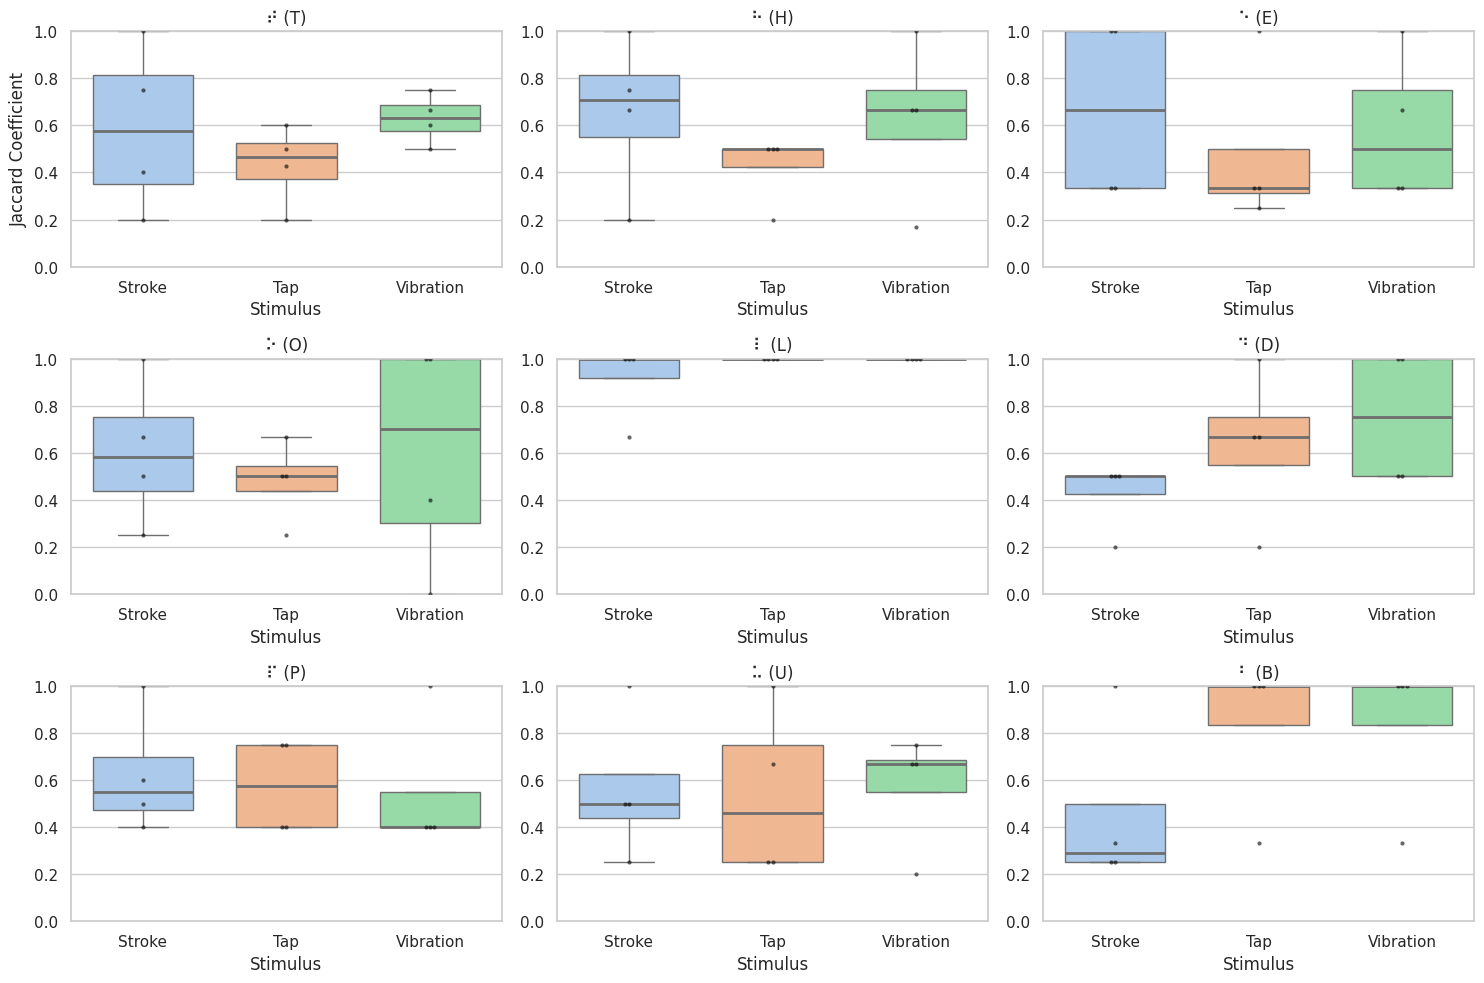

In [7]:
print_boxplots_and_tests(dataframe_no_tests, pdf_name="Test_single_char", plotting_order=["t", "h", "e", "o", "l", "d", "p", "u", "b"])

# Test results

### Boxplot for the Test words

<ipython-input-6-7e9d8ea100de>:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)


Medians for 'the':
  Vibration: 0.4277777777777777
  Stroke: 0.31666666666666665
  Tap: 0.43055555555555547
Levene's Test: p-value = 0.30088251969759433, stat: 1.3765752409191998 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.3511, p-value: 0.8390	Significant difference between datasets: False
eta_squared: 0.03191489361702133



Medians for 'old':
  Vibration: 0.6499999999999999
  Stroke: 0.47777777777777775
  Tap: 0.5611111111111111
Levene's Test: p-value = 0.5348366753859998, stat: 0.6713961407491486 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 3.6406, p-value: 0.1620	Significant difference between datasets: False
eta_squared: 0.330960854092527



Medians for 'pub':
  Vibration: 0.611111111111111
  Stroke: 0.4583333333333333
  Tap: 0.5333333333333333
Levene's Test: p-value = 0.7898889216691855, stat: 0.2421536327379923 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 1.0569, p-value: 0.5895	Significant difference between datasets: False
eta_squared:

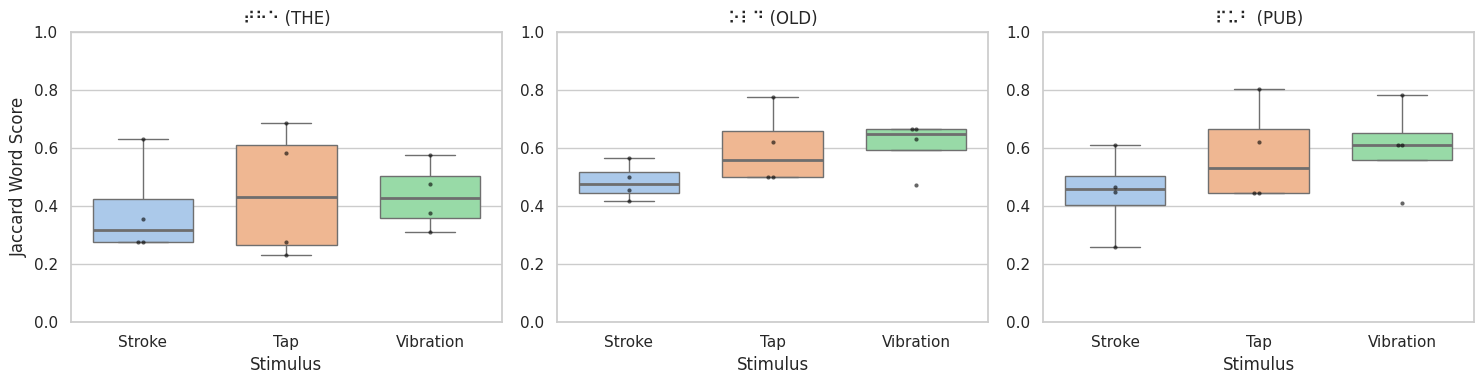

In [8]:
print_boxplots_and_tests(pd.concat(data.copy(), ignore_index=True), score="jaccard_word_score", pdf_name="JaccardTest", plotting_order=["the", "old", "pub"])

# Specific character investigation

### Boxplots for the specific characters in the **tested words**

Medians for 't':
  Vibration: 0.5
  Stroke: 0.45
  Tap: 0.5
Levene's Test: p-value = 0.32461543033799234, stat: 1.278260869565217 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.7575, p-value: 0.6847	Significant difference between datasets: False
eta_squared: 0.0688679245283022



Medians for 'h':
  Vibration: 0.30000000000000004
  Stroke: 0.25
  Tap: 0.43333333333333335
Levene's Test: p-value = 0.965966813683461, stat: 0.03475935828877006 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.4865, p-value: 0.7841	Significant difference between datasets: False
eta_squared: 0.0442238267148015



Medians for 'e':
  Vibration: 0.3333333333333333
  Stroke: 0.3333333333333333
  Tap: 0.3333333333333333
Levene's Test: p-value = 0.6337591893817014, stat: 0.48 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.1447, p-value: 0.9302	Significant difference between datasets: False
eta_squared: 0.013157894736842667



Medians for 'o':
  Vibration: 0.5
  Stroke: 0.5
  Tap:

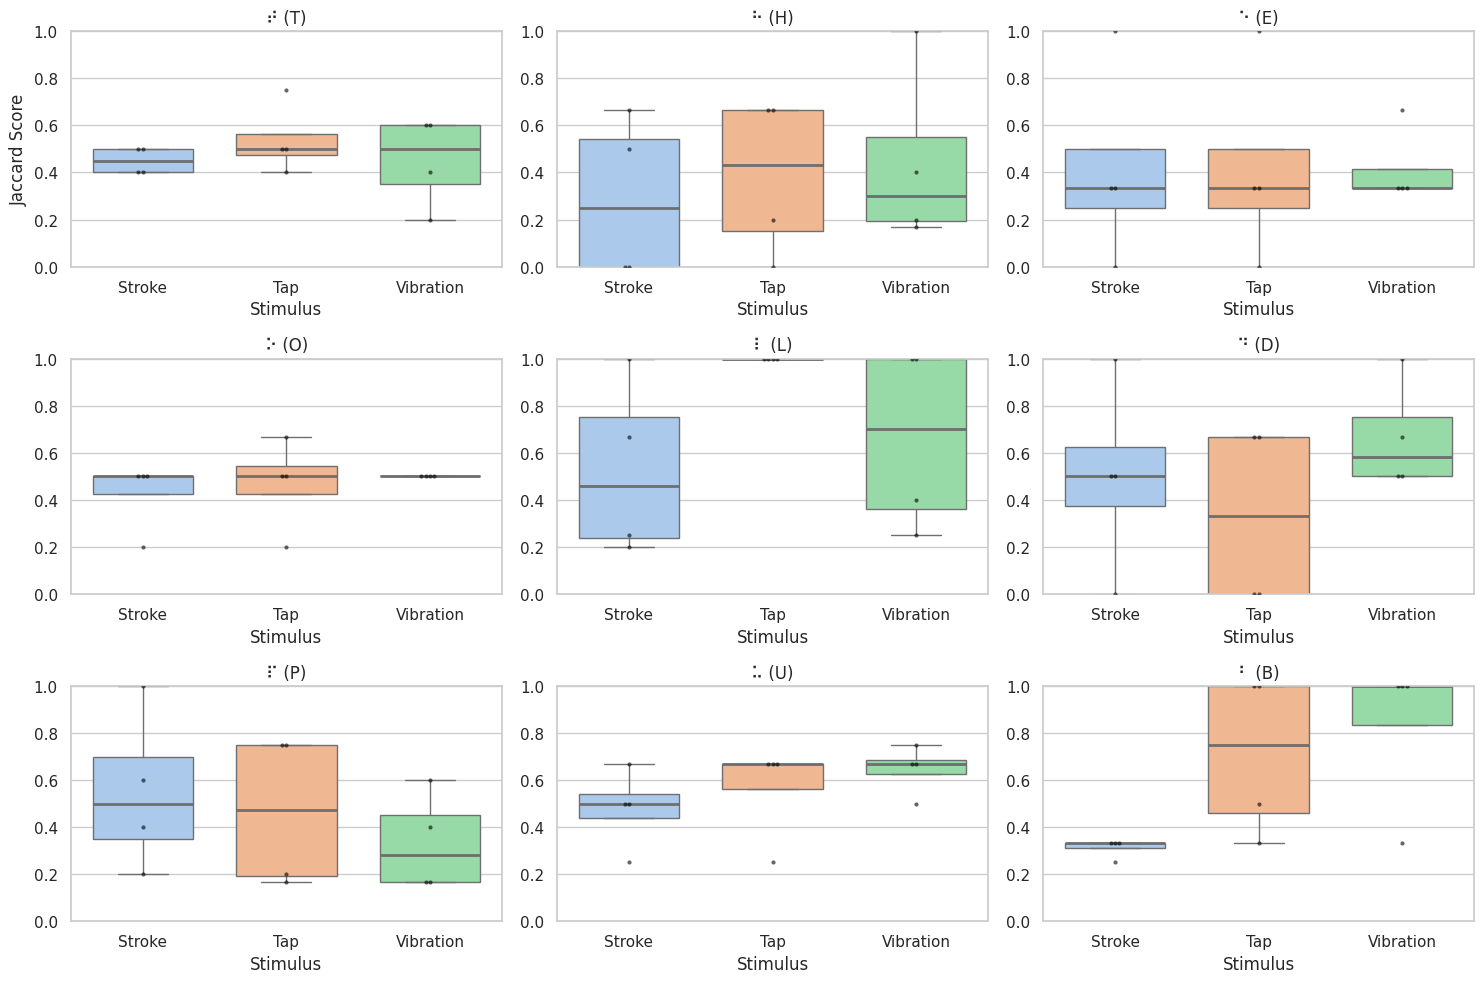

In [9]:
print_boxplots_and_tests(analysed_data, score="Jaccard Score", pdf_name="boxplot_with_swarm_single_chars_test", plotting_order=['t', 'h', 'e', 'o', 'l', 'd', 'p', 'u', 'b'], groupable=False)

## Investigation of the wrong Keypresses

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_character_counts_new(df:pd.DataFrame, plot_name:str=""):
    """Plot bar charts for 'Tested Character' and 'Surplus Character' counts per 'Condition'."""
    plt.figure(figsize=(15, 10))

    conditions = df['Condition'].unique()
    num_conditions = len(conditions)

    for i, condition in enumerate(conditions):
        condition_data = df[df['Condition'] == condition]

        for col, title, color, pos in zip(['Missed Character', 'Surplus Character'],
                                           ["FN (Missed)", "FP (Surplus)"],
                                           ["Blues_d", "Oranges_d"],
                                           [1, 2]):
            # condition_data[col] = condition_data[col].apply(lambda x: [numbers_encoding.get(c, c) for c in list(x)])
            condition_data.loc[:, col] = condition_data[col].apply(lambda x: [numbers_encoding.get(c, c) for c in list(x)])
            counts = condition_data[col].explode().value_counts()

            ax = plt.subplot(num_conditions, 2, i * 2 + pos)
            sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=color, ax=ax, legend=False)

            ax.set_title(f"{condition} - {title}", fontsize=14)
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Count', fontsize=12)

            # Fix UserWarning by setting ticks explicitly
            ax.set_xticks(range(len(counts.index)))
            ax.set_xticklabels(counts.index, rotation=45, fontsize=12)

    plt.tight_layout()
    plt.savefig(f'/content/{plot_name}.pdf', format='pdf')



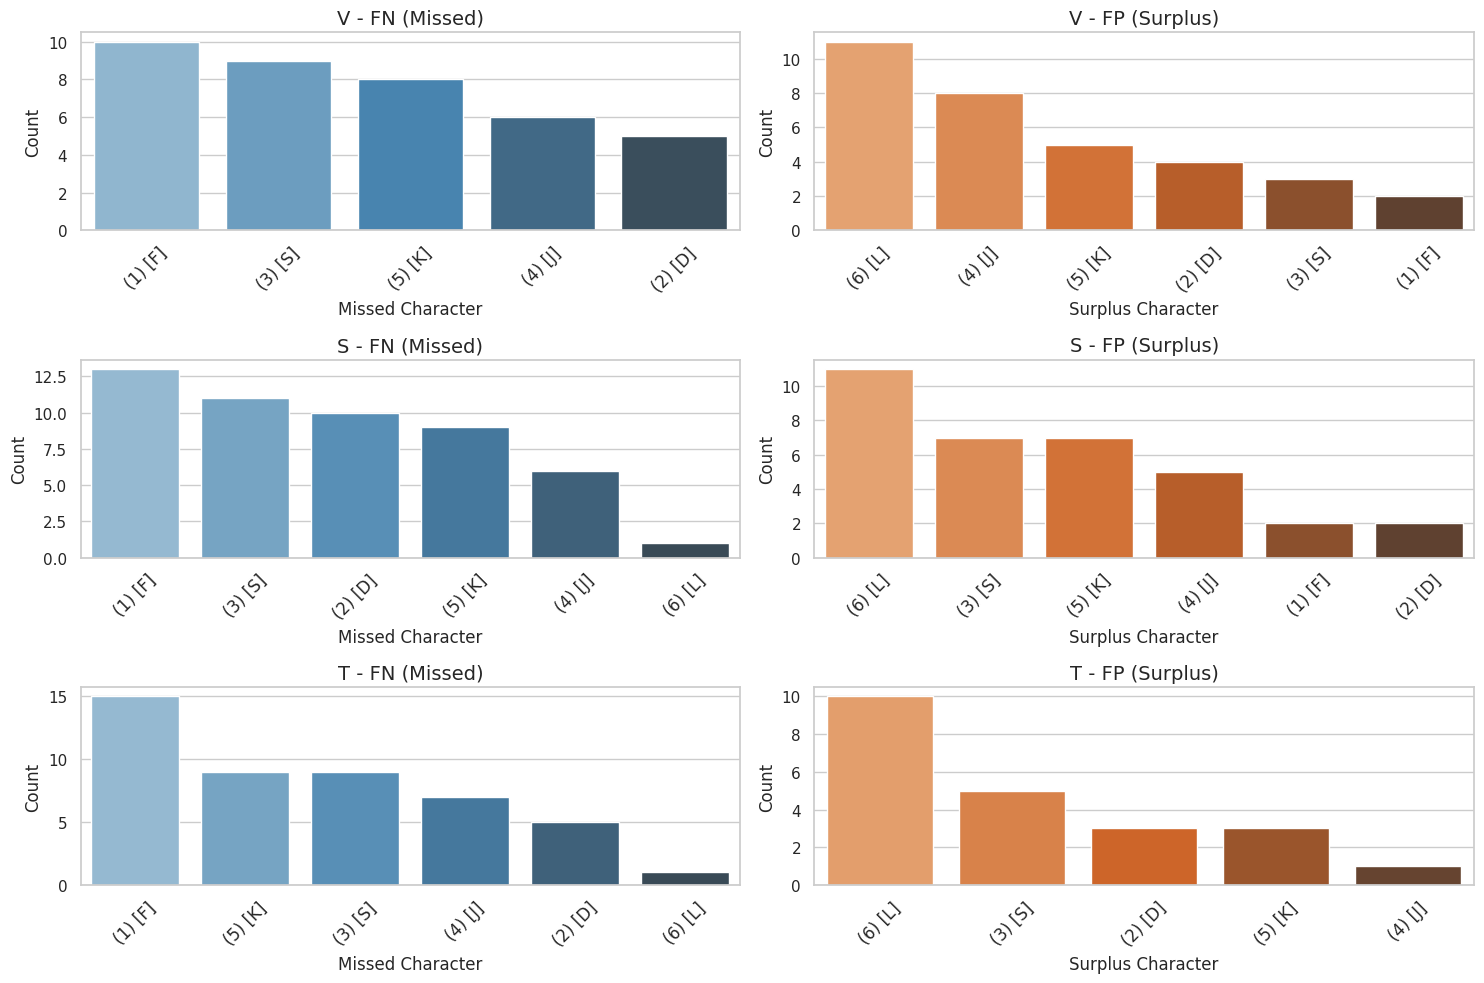

In [11]:
plot_character_counts_new(analysed_data[['Condition', 'Tested Character', 'Missed Character', 'Surplus Character', 'F1']].copy(), plot_name = "columnChart")


## Wrong Keypresses **given Braille Character** plotted as Heatmap

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_matrix(condition_df:pd.DataFrame, tested_chars:list)->tuple:
  """
    Calculate the matrix of missed and surplus characters for each tested character.

    Parameters:
        condition_df (pd.DataFrame): DataFrame containing 'Tested Character', 'Missed Character', and 'Surplus Character'.
        tested_chars (list): List of characters that are being tested.

    Returns:
        tuple: A tuple containing:
            - total_tested_char_matrix (dict): A dictionary with tested characters as keys and the total count of occurrences as values.
            - missed_char_matrix (pd.DataFrame): DataFrame containing counts of missed characters for each tested character.
            - surplus_char_matrix (pd.DataFrame): DataFrame containing counts of surplus characters for each tested character.
    """

  missed_char_matrix = {tested_char: {missed_char: 0 for missed_char in keyset} for tested_char in tested_chars}
  surplus_char_matrix = {tested_char: {surplus_char: 0 for surplus_char in keyset} for tested_char in tested_chars}
  total_tested_char_matrix = {tested_char: 0 for tested_char in tested_chars}

  for _, row in condition_df.iterrows():
    tested_character = row['Tested Character']
    missed_chars = row['Missed Character']  # This is a set

    for missed_char in missed_chars:
        if missed_char in keyset:
            missed_char_matrix[tested_character][missed_char] += 1

    surplus_chars = row['Surplus Character']  # This is a set
    for surplus_char in surplus_chars:
        if surplus_char in keyset:
            surplus_char_matrix[tested_character][surplus_char] += 1

    total_tested_char_matrix[tested_character] += 1
  return total_tested_char_matrix, pd.DataFrame(missed_char_matrix), pd.DataFrame(surplus_char_matrix)


def calculate_percentages(missed_char_df:pd.DataFrame, surplus_char_df:pd.DataFrame, tested_chars:list, total_tested_char_matrix:dict)->tuple:
  """
    Calculate the percentages of missed and surplus characters for each tested character.

    Parameters:
        missed_char_df (pd.DataFrame): DataFrame containing counts of missed characters for each tested character.
        surplus_char_df (pd.DataFrame): DataFrame containing counts of surplus characters for each tested character.
        tested_chars (list): List of characters that are being tested.
        total_tested_char_matrix (dict): A dictionary containing the total occurrences of each tested character.

    Returns:
        tuple: A tuple containing:
            - missed_char_percentage_df (pd.DataFrame): DataFrame containing percentages of missed characters for each tested character.
            - surplus_char_percentage_df (pd.DataFrame): DataFrame containing percentages of surplus characters for each tested character.
    """
  missed_char_percentage_df = missed_char_df.copy()
  surplus_char_percentage_df = surplus_char_df.copy()

  for tested_char in tested_chars:
      total_tested_char = total_tested_char_matrix[tested_char]

      if total_tested_char > 0:
          missed_char_percentage_df[tested_char] = (missed_char_df[tested_char] / total_tested_char) * 100
          surplus_char_percentage_df[tested_char] = (surplus_char_df[tested_char] / total_tested_char) * 100
      else:
          missed_char_percentage_df[tested_char] = 0
          surplus_char_percentage_df[tested_char] = 0

  missed_char_percentage_df = missed_char_percentage_df.rename(index=braille_character, columns=braille_character)
  surplus_char_percentage_df = surplus_char_percentage_df.rename(index=braille_character, columns=braille_character)

  missed_char_percentage_df = missed_char_percentage_df.rename(index=numbers_encoding)
  surplus_char_percentage_df = surplus_char_percentage_df.rename(index=numbers_encoding)
  return missed_char_percentage_df, surplus_char_percentage_df


def generate_heatmap(sns, data:pd.DataFrame, tested_chars:list, falseNegative:bool = False, percentages:bool = False):
  """
    Generate a heatmap to visualize the relationships between the tested characters and missed/surplus characters.

    Parameters:
        sns (module): Seaborn module used for generating the heatmap.
        data (pd.DataFrame): DataFrame containing the values to be visualized in the heatmap.
        tested_chars (list): List of characters that are being tested.
        falseNegative (bool, optional): Flag to determine if the heatmap represents missed characters (default is False).
        percentages (bool, optional): Flag to determine if the heatmap represents percentages (default is False).
    """
  x_tick_labels = [braille_character.get(c, c) for c in tested_chars]
  y_tick_labels = [numbers_encoding.get(c, c) for c in keyset]
  fmt = ".1f" if percentages else "d"
  color = "Blues" if falseNegative else "Oranges"

  sns.heatmap(data, annot=True, cmap=color, fmt=fmt, cbar=False,
              xticklabels=x_tick_labels,
              yticklabels=y_tick_labels)


def generate_heatmap_plot(plt, plt_nr:int, data:pd.DataFrame, tested_chars:list, percentages:bool, condition:str):
  """
    Generate a subplot of the heatmap for either missed or surplus characters.

    Parameters:
        plt (module): Matplotlib module used for plotting.
        plt_nr (int): The plot number (1 or 2) for determining the left or right subplot.
        data (pd.DataFrame): DataFrame containing the values to be visualized in the heatmap.
        tested_chars (list): List of characters that are being tested.
        percentages (bool): Flag to determine if the heatmap represents percentages.
        condition (str): The condition name (e.g., test or scenario) for the heatmap title.
    """
  plt.subplot(1, 2, plt_nr)
  falseNegative = True if plt_nr == 1 else False
  generate_heatmap(sns, data, tested_chars, falseNegative=falseNegative, percentages=percentages)
  plt.title(f'{condition} - FN (Missed) Key(s)')
  plt.xlabel('Tested Character')
  plt.ylabel('FN (Missed) Key(s)')
  plt.xticks(rotation=45, ha="right")
  plt.yticks(rotation=0)


def plot_character_correlations_by_condition(df:pd.DataFrame, percentages:bool, plot_name:str):
    """
    Plot correlation matrices for each condition, showing the relationship between the 'Tested Character'
    and the 'Missed Character' and 'Surplus Character' with percentage values.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Condition', 'Tested Character',
                           'Missed Character', and 'Surplus Character' columns.
        percentages (bool): Flag to determine if the heatmap uses percentages.
        name (str): The name used in the output file name for saving the heatmap PDF.

    Returns:
        None: Saves the heatmap plots as PDF files for each condition.
    """
    tested_chars = ["t", "h", "e", "o", "l", "d", "p", "u", "b"]
    conditions = df['Condition'].unique()

    for condition in conditions:
        condition_df = df[df['Condition'] == condition]
        total_tested_char_matrix, missed_char_df, surplus_char_df = calculate_matrix(condition_df, tested_chars)
        missed_char_percentage_df, surplus_char_percentage_df = calculate_percentages(missed_char_df, surplus_char_df, tested_chars, total_tested_char_matrix)

        plt.figure(figsize=(15, 6))
        data = missed_char_percentage_df if percentages else missed_char_df
        generate_heatmap_plot(plt, 1, data, tested_chars, percentages, condition)

        data = surplus_char_percentage_df if percentages else surplus_char_df
        generate_heatmap_plot(plt, 2, data, tested_chars, percentages, condition)

        plt.tight_layout()
        plt.savefig(f'/content/heatmap_{condition}_{plot_name}.pdf', format='pdf')


### Heatmap (counts)

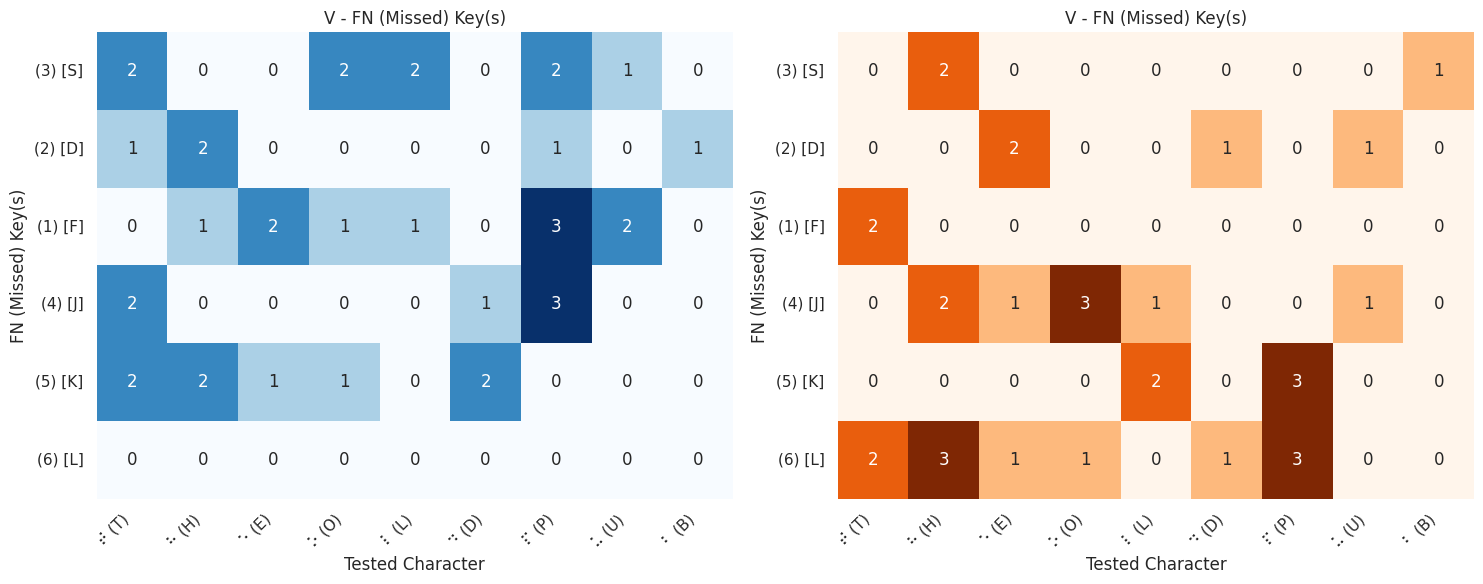

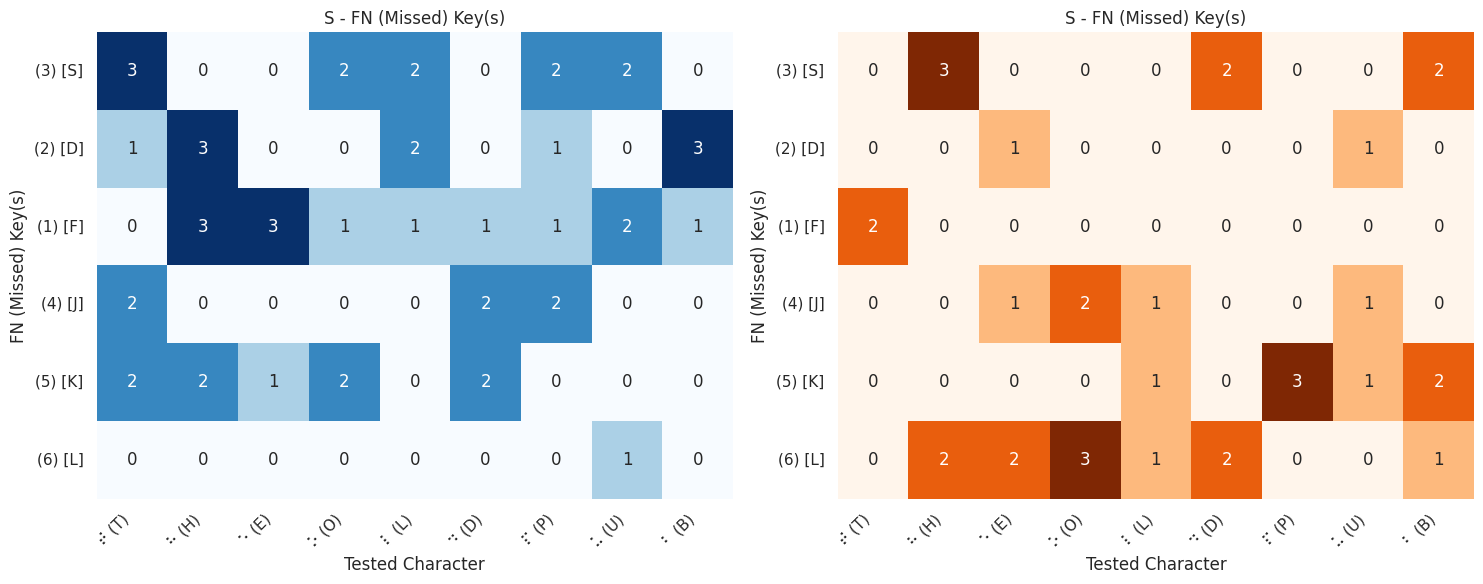

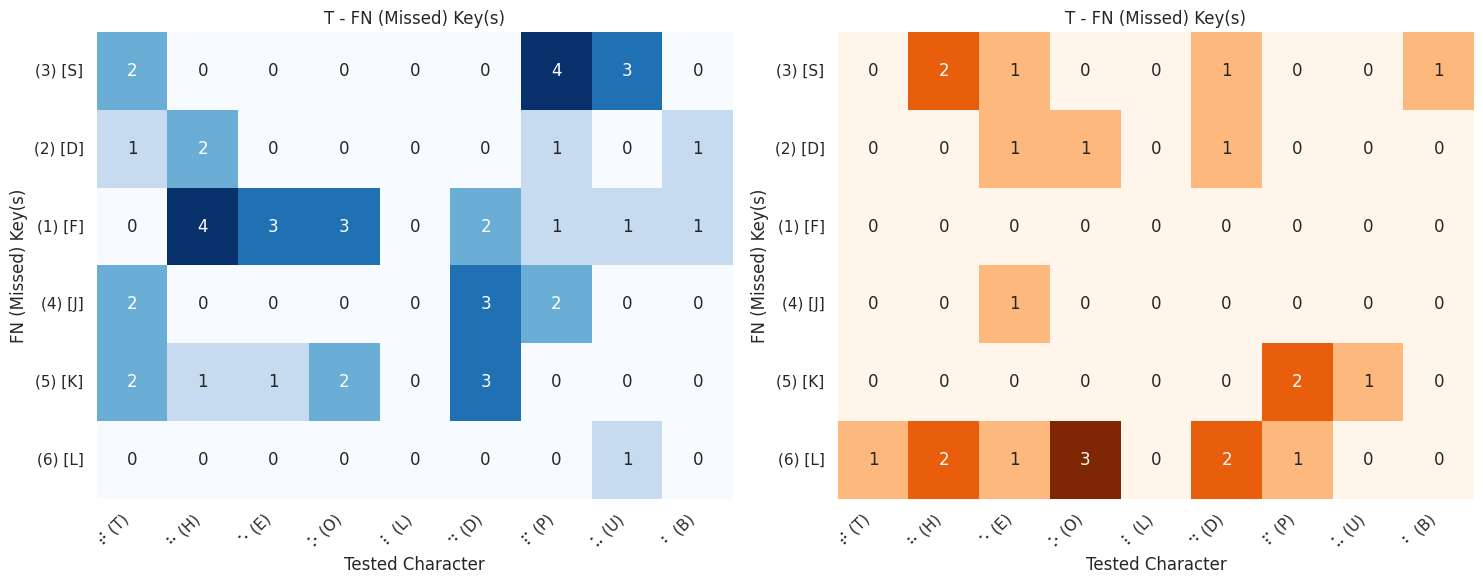

In [13]:
plot_character_correlations_by_condition(analysed_data, False, "correlations_by_conditions_counts")

### Heatmaps (percentages)

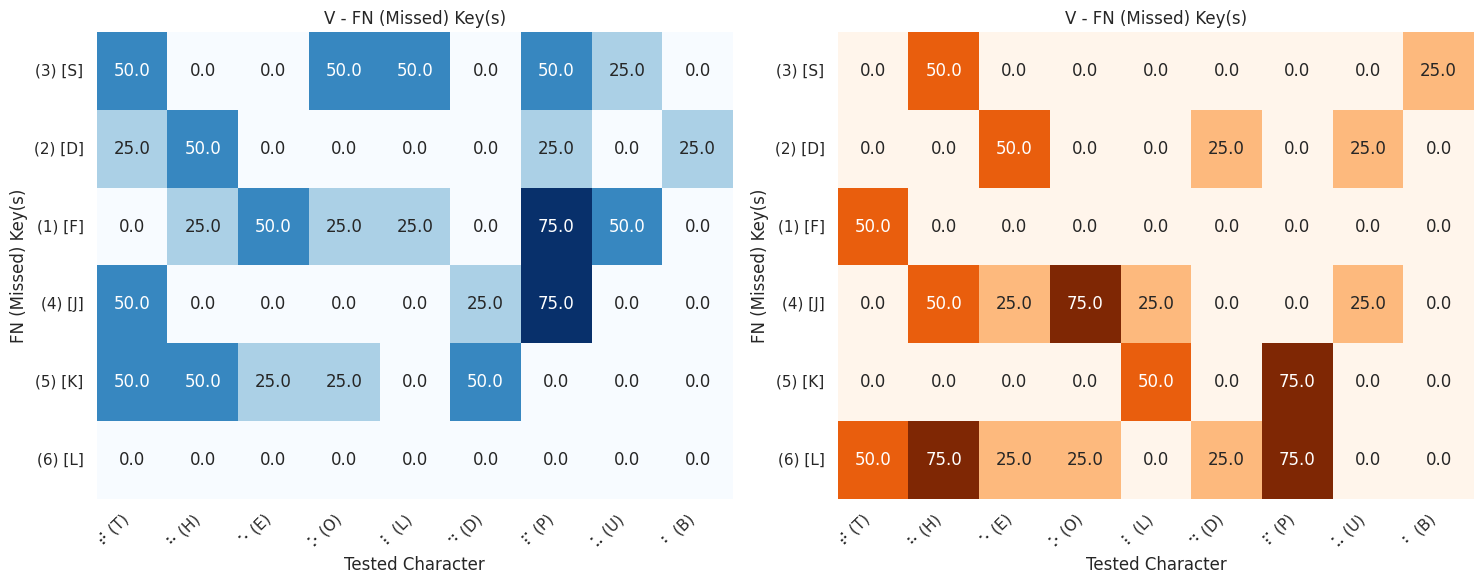

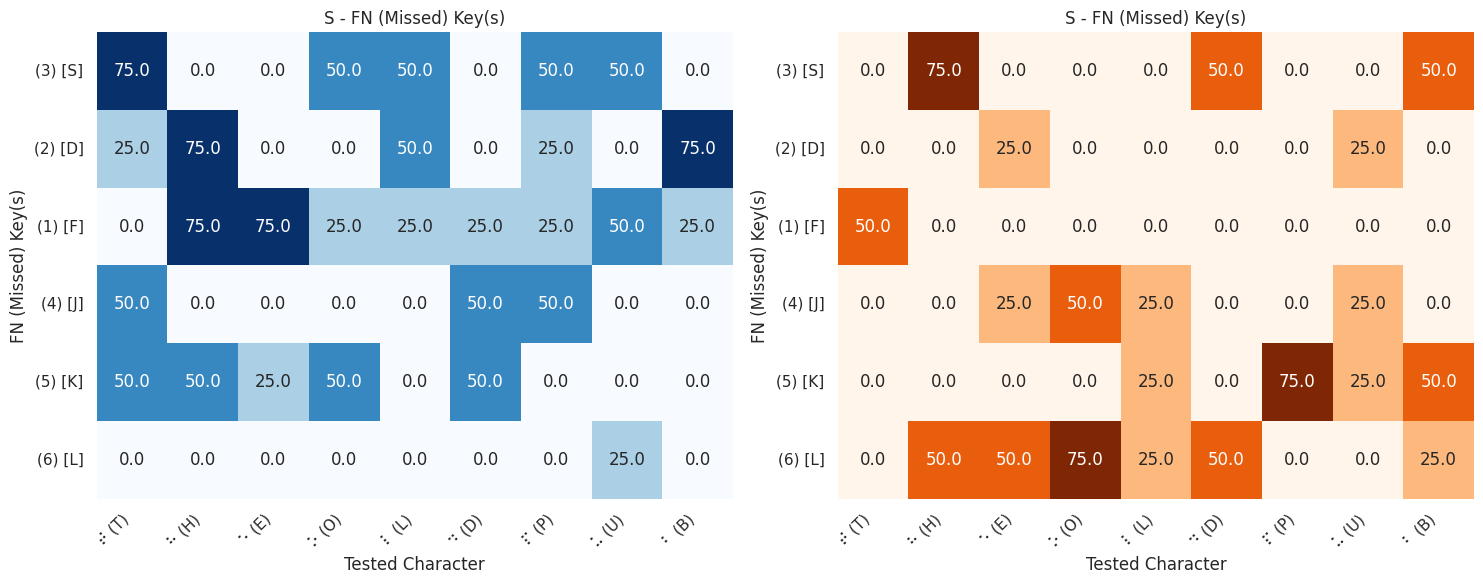

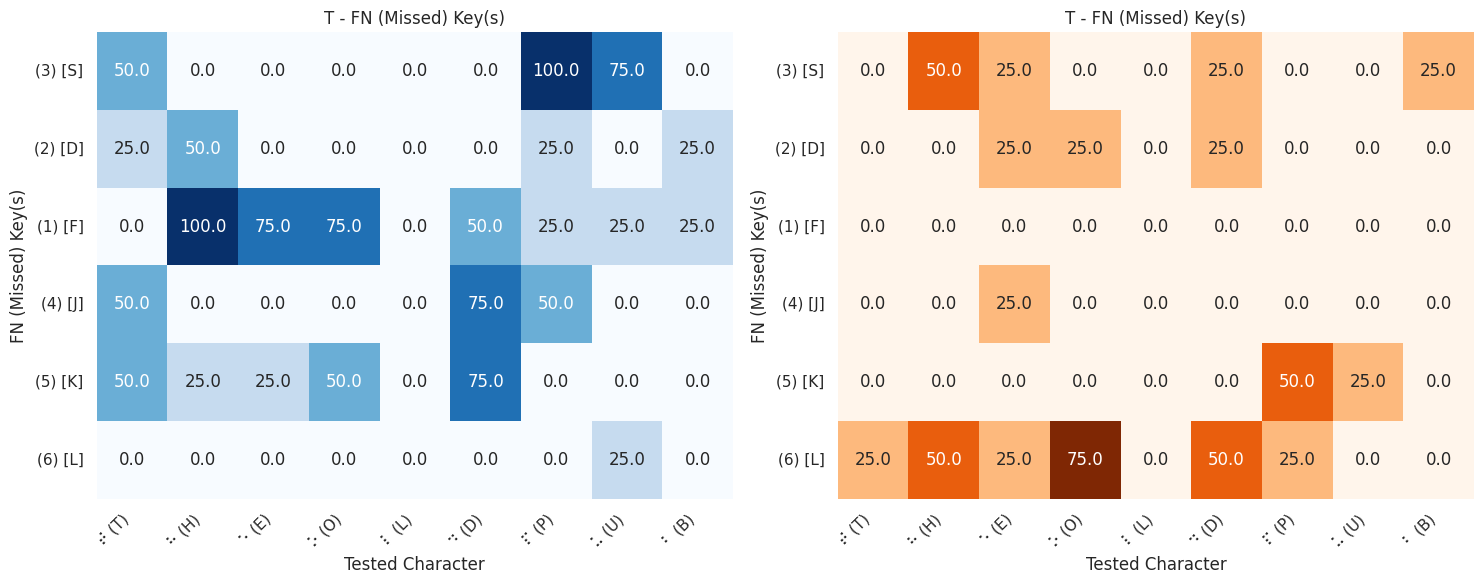

In [14]:
plot_character_correlations_by_condition(analysed_data, True, "correlations_by_conditions_percentages")

## Plot PLA

In [15]:
# def one_hot_encode_submitted_value(df:pd.DataFrame) ->pd.DataFrame:
#     """
#     One-hot encode the 'Submitted Value' column in the dataframe.

#     Parameters:
#         df (pd.DataFrame): DataFrame containing 'Condition', 'Submitted Value', 'Ground Truth' columns.

#     Returns:
#         pd.DataFrame: DataFrame with one-hot encoded 'Submitted Value'.
#     """
#     for value in keyset:
#       df[f"Submitted_Value_{value}"] = df['Submitted Value'].apply(lambda x: 1 if value in x else 0)

#     return df

# # Apply the one-hot encoding function
# analysed_test_data_encoding = one_hot_encode_submitted_value(analysed_data)


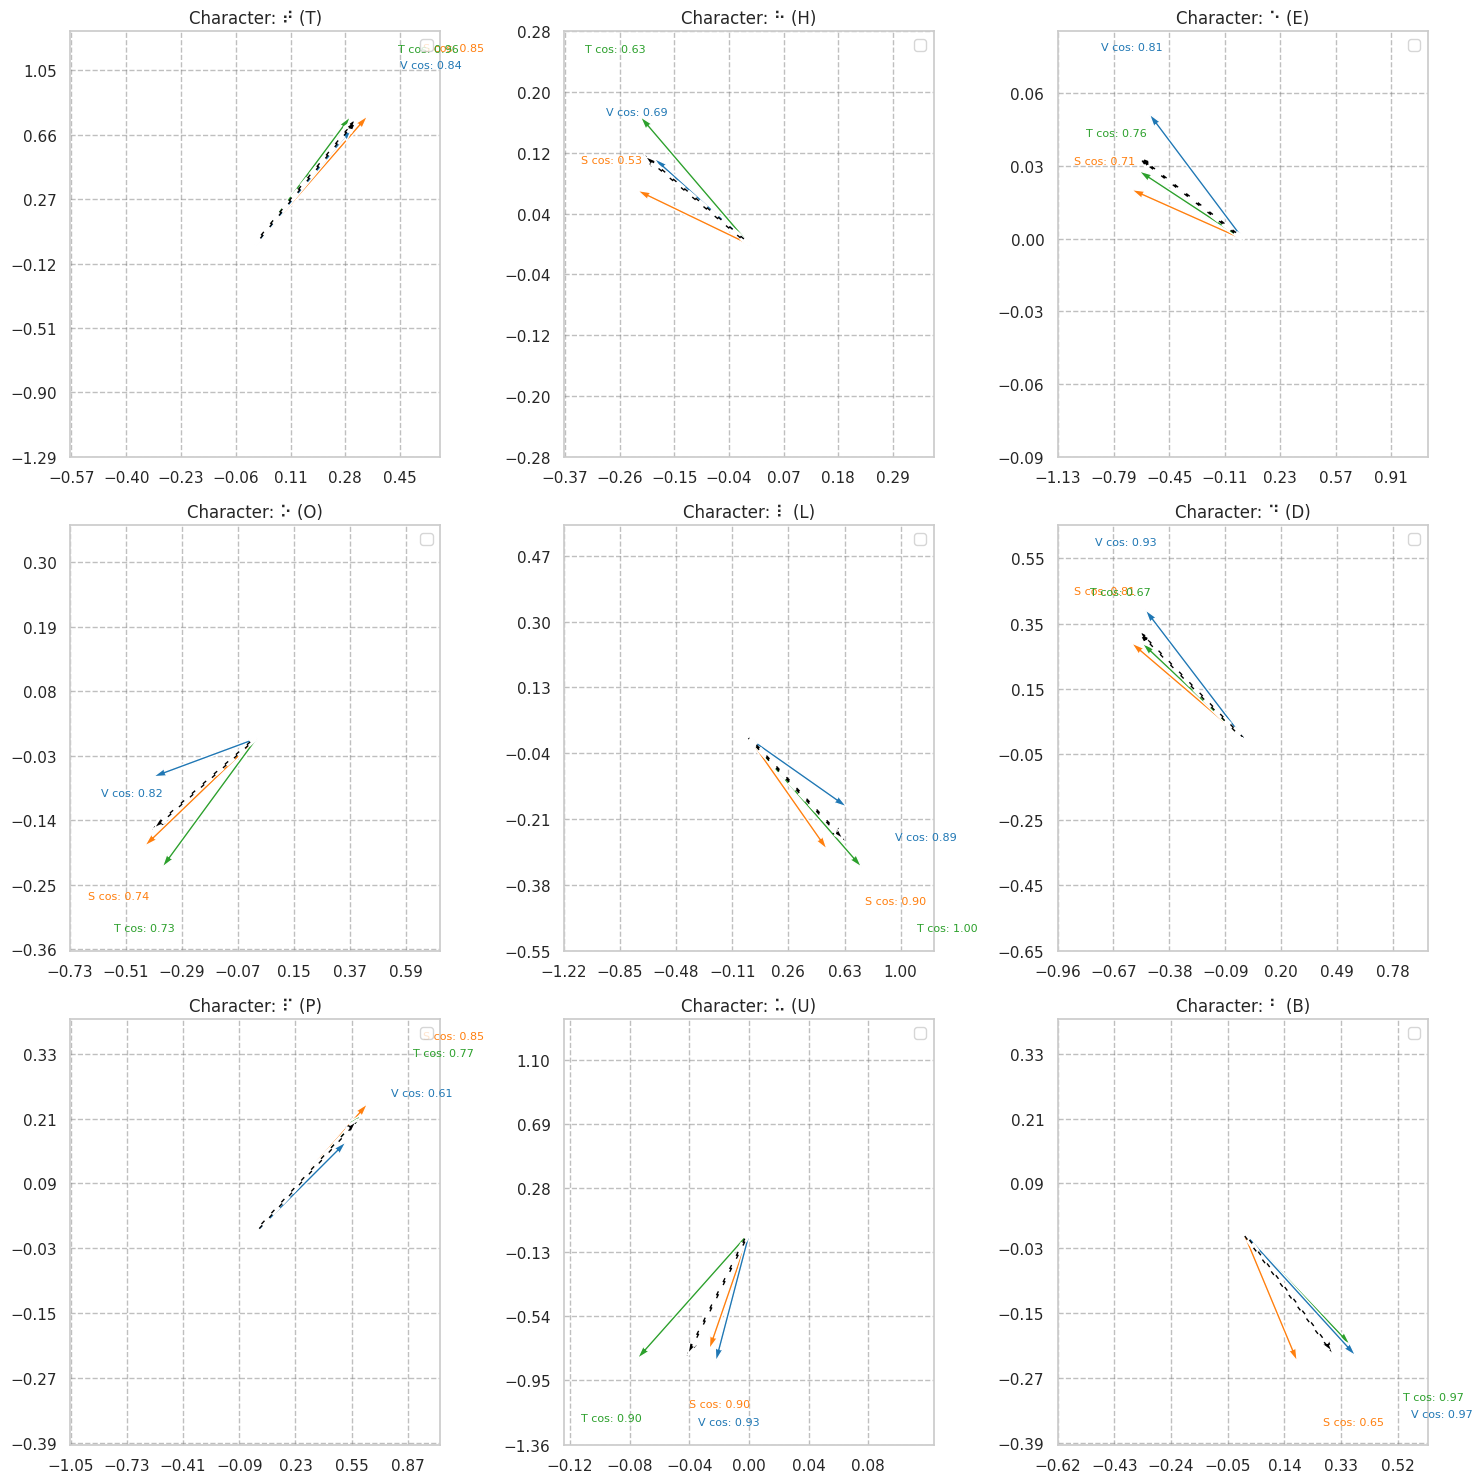

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

def one_hot_encode_submitted_value(df:pd.DataFrame)->pd.DataFrame:
    """
    One-hot encode the 'Submitted Value' column in the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Condition', 'Submitted Value', 'Ground Truth' columns.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded 'Submitted Value' and 'Ground Truth'.
    """
    # Define the possible values for 'Submitted Value' and 'Ground Truth'
    possible_values = ["s", "d", "f", "j", "k", "l"]

    # One-hot encode 'Submitted Value'
    for value in possible_values:
        df[f"Submitted_Value_{value}"] = df['Submitted Value'].apply(lambda x: 1 if value in x else 0)

    # One-hot encode 'Ground Truth'
    for value in possible_values:
        df[f"Ground_Truth_{value}"] = df['Ground Truth'].apply(lambda x: 1 if value in x else 0)

    return df

def plotting_helper(ax, filtered_group:pd.DataFrame, reduced_data:np.ndarray, condition_color_map:dict, one_hot_columns:list, ground_truth_columns:list, tested_char:str):
  """
    A helper function to plot PCA vectors for a given tested character and condition, including the following:
    - One-hot encoded vectors for 'Submitted Value' and 'Ground Truth'
    - Calculating and displaying cosine similarity for each condition
    - Plotting the ground truth vector for all conditions of the current tested character
    - Customizing axis ticks, limits, and adding a title for each subplot

    Parameters:
        ax (matplotlib.axes.Axes): The axes object to plot the vectors onto.
        filtered_group (pd.DataFrame): DataFrame containing the grouped data for a single tested character.
        reduced_data (np.ndarray): The PCA-reduced data for the given tested character and conditions.
        condition_color_map (dict): A mapping of conditions to colors for each vector's plot.
        one_hot_columns (list): A list of column names representing the one-hot encoded 'Submitted Value' vectors.
        ground_truth_columns (list): A list of column names representing the one-hot encoded 'Ground Truth' vectors.
        tested_char (str): The character being tested (e.g., 't', 'h', 'e', etc.).

    Returns:
        None: This function modifies the provided `ax` object in place to add the plot for the given tested character.
  """
  for j, condition in enumerate(filtered_group['Condition']):
      avg_vector = reduced_data[j]
      color = condition_color_map[condition]

      ax.quiver(0, 0, avg_vector[0], avg_vector[1], angles='xy', scale_units='xy', scale=1.5,
                color=color, linewidth=1)

      # Calculate the cosine similarity between 'Submitted Value' vector and 'Ground Truth' vector
      submitted_value_vector = filtered_group.iloc[j][one_hot_columns].values.reshape(1, -1)
      ground_truth_vector = filtered_group.iloc[j][ground_truth_columns].values.reshape(1, -1)
      cos_sim = cosine_similarity(submitted_value_vector, ground_truth_vector)[0][0]

      # Add cosine similarity to the label
      ax.text(avg_vector[0], avg_vector[1], f"{condition.upper()} cos: {cos_sim:.2f}", fontsize=8, color=color)

  # Plot the ground truth vector (same for all conditions in the character)
  ground_truth_vector = reduced_data.mean(axis=0)  # Average vector for ground truth (since it's the same for all conditions)
  ax.quiver(0, 0, ground_truth_vector[0], ground_truth_vector[1], angles='xy', scale_units='xy', scale=1.5,
            color='black', linewidth=2, linestyle='--', pivot='tail')

  # Set axis limits for this plot
  max_x = np.max(np.abs(reduced_data[:, 0]))
  max_y = np.max(np.abs(reduced_data[:, 1]))
  ax.set_xlim(-max_x * 1.1, max_x * 1.1)
  ax.set_ylim(-max_y * 1.1, max_y * 1.1)

  # Set custom tick marks for better visibility
  ax.set_xticks(np.arange(round(-max_x * 1.1 *100)/100, round(max_x * 1.1 * 100)/100, round(max_x/3*100)/100.0))  # Custom tick marks for x-axis
  ax.set_yticks(np.arange(round(-max_y * 1.1 *100)/100.0, round(max_y * 1.1 * 100)/100.0, round(max_y/3*100)/100.0))  # Custom tick marks for y-axis
  ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

  ax.set_title(f"Character: {braille_character[tested_char]}")

  # Add a legend
  handles, labels_legend = ax.get_legend_handles_labels()
  ax.legend(handles, labels_legend, loc='upper right')


def plot_pca_for_grouped_data(df_encoded:pd.DataFrame, pdf_name:str=""):
    """
    Plot PCA visualization for one-hot encoded 'Submitted Value' and 'Ground Truth' vectors, with labels for each condition,
    and create plots for each 'Tested Character' in a 3x3 grid. Vectors with the same 'Tested Character'
    and 'Condition' are merged and averaged.

    Parameters:
        df_encoded (pd.DataFrame): DataFrame containing 'Submitted Value', 'Ground Truth', 'Tested Character', 'Condition',
                                   and one-hot encoded columns for 'Submitted_Value_s', 'Submitted_Value_d',
                                   'Submitted_Value_f', 'Submitted_Value_j', 'Submitted_Value_k', 'Submitted_Value_l',
                                   'Ground_Truth_s', 'Ground_Truth_d', 'Ground_Truth_f', 'Ground_Truth_j', 'Ground_Truth_k', 'Ground_Truth_l'.
    """
    # Extract relevant columns for one-hot encoding
    one_hot_columns = ["Submitted_Value_s", "Submitted_Value_d", "Submitted_Value_f", "Submitted_Value_j", "Submitted_Value_k", "Submitted_Value_l"]
    ground_truth_columns = ["Ground_Truth_s", "Ground_Truth_d", "Ground_Truth_f", "Ground_Truth_j", "Ground_Truth_k", "Ground_Truth_l"]
    grouped = df_encoded.groupby(["Tested Character", "Condition"])[one_hot_columns + ground_truth_columns].mean().reset_index()

    encodings_matrix = grouped[one_hot_columns + ground_truth_columns].values
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(encodings_matrix)

    conditions = df_encoded['Condition'].unique()
    condition_colors = sns.color_palette("tab10", len(conditions))  # Using seaborn's color palette
    condition_color_map = {condition: condition_colors[i] for i, condition in enumerate(conditions)}
    tested_characters = ['t', 'h', 'e', 'o', 'l', 'd', 'p', 'u', 'b']

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for i, tested_char in enumerate(tested_characters):
        ax = axes[i]
        filtered_group = grouped[grouped['Tested Character'] == tested_char]
        encodings_matrix = filtered_group[one_hot_columns + ground_truth_columns].values
        reduced_data = pca.transform(encodings_matrix)
        plotting_helper(ax, filtered_group, reduced_data, condition_color_map, one_hot_columns, ground_truth_columns, tested_char)

    plt.tight_layout()
    plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')

analysed_test_data_encoding = one_hot_encode_submitted_value(analysed_data)
plot_pca_for_grouped_data(analysed_test_data_encoding, pdf_name="vector")


In [17]:
def calculateFriedmanAndKendallsW(data1,data2,data3):
  stat, p_value = friedmanchisquare(data1, data2,data3)

  print(f"Friedman test statistic: {stat:.4f}, p-value: {p_value:.4f}")

  # Interpretation
  if p_value < 0.05:
      print("Significant difference found between conditions.")
  else:
      print("No significant difference found between conditions.")

  calculateKendallsW(len(data1), 3, stat, p_value)


def calculateKendallsW(N,k,testStatistic, p_value):
  kendalls_w = testStatistic / (N * (k - 1))

  # Print results
  print(f"Friedman Test Statistic (χ²): {testStatistic:.4f}, p-value: {p_value:.4f}")
  print(f"Kendall's W: {kendalls_w:.4f}")

In [18]:
from scipy.stats import friedmanchisquare

def createSortedDatasets(dataFrame, condition = ["S", "T", "V"]):
  sortedSets = []
  for cond in condition:
    sortedData = filterDataFrame(cond, dataFrame, "Condition").groupby("ParticipantID", as_index=False)["jaccard_coefficient"].mean().sort_values("ParticipantID")
    sortedSets.append(sortedData)
  return sortedSets

In [19]:
print("Learning Data")
learnData = createSortedDatasets(dataframe_no_tests[["jaccard_coefficient", "Test", "ParticipantID", "Condition"]].copy())
calculateFriedmanAndKendallsW(learnData[0]["jaccard_coefficient"].values, learnData[1]["jaccard_coefficient"].values, learnData[2]["jaccard_coefficient"].values)

Learning Data
Friedman test statistic: 2.4255, p-value: 0.2974
No significant difference found between conditions.
Friedman Test Statistic (χ²): 2.4255, p-value: 0.2974
Kendall's W: 0.1011


In [20]:
print("Testing data")
tmp1 = dataframe_tests_V_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()
tmp2 = dataframe_tests_S_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()
tmp3 = dataframe_tests_T_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()

scores_cond1 = tmp1.sort_values("ParticipantID")["jaccard_word_score"].values
scores_cond2 = tmp2.sort_values("ParticipantID")["jaccard_word_score"].values
scores_cond3 = tmp3.sort_values("ParticipantID")["jaccard_word_score"].values

stat, p_value = friedmanchisquare(scores_cond1, scores_cond2, scores_cond3)
calculateFriedmanAndKendallsW(scores_cond1,scores_cond2,scores_cond3)

Testing data
Friedman test statistic: 3.5000, p-value: 0.1738
No significant difference found between conditions.
Friedman Test Statistic (χ²): 3.5000, p-value: 0.1738
Kendall's W: 0.1458


In [21]:
def stitchTogether(participant, condition, participantDataOrder=participantDataOrder):
    id_to_name = {entry[0]: entry[2] for entry in participantDataOrder}
    name = id_to_name.get(participant)
    array =["the", "old", "pub"]
    return array[name.index(condition)]

def createSortedDatasetsNew(dataFrame, condition = ["S", "T", "V"]):
  sortedSets = []
  for cond in condition:
    sortedData = filterDataFrame(cond, dataFrame, "Condition").groupby("ParticipantID", as_index=False)["jaccard_coefficient"].mean().sort_values("ParticipantID")
    # Apply to a single new column:
    sortedData["Test"] = sortedData.apply(
        lambda row: stitchTogether(row["ParticipantID"], cond),
        axis=1
    )
    sortedData["Condition"] = cond
    sortedSets.append(sortedData)
  return sortedSets


learnData = createSortedDatasetsNew(dataframe_no_tests[["jaccard_coefficient", "Test", "ParticipantID", "Condition"]].copy())
learnDataFrame = pd.concat(learnData)

In [22]:
testData = createSortedDatasetsNew(dataframe_no_tests[["jaccard_coefficient", "Test", "ParticipantID", "Condition"]].copy())

v_jaccard_test = dataframe_tests_V_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()
s_jaccard_test = dataframe_tests_S_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()
t_jaccard_test = dataframe_tests_T_maxJaccard[["ParticipantID","Condition","jaccard_word_score"]].copy()

threeDimensionSet = pd.concat([v_jaccard_test,s_jaccard_test,t_jaccard_test])

In [23]:
def plot_boxplot_with_swarmplot_new(data:pd.DataFrame, score:str, test:str, i:int):
  """
  Plot the boxplot for a given test with a swarmplot on top.

  Parameters:
      data (pd.DataFrame): Data filtered for the specific test.
      score (str): The score column to plot.
      test (str): The test name for the title.
      i (int): The index of the subplot.
  """
  condition_order = ["Stroke", "Tap", "Vibration"]
  condition_palette = {
      "Stroke": pastel_colors[0],  # First color in the pastel palette
      "Tap": pastel_colors[1],     # Second color in the pastel palette
      "Vibration": pastel_colors[2]  # Third color in the pastel palette
  }
  # Plot the boxplot
  sns.boxplot(
      x='Condition',
      y=score,
      data=data,
      showfliers=False,
      palette=condition_palette,
      order=condition_order,
      width=0.7,
      dodge=False,  # Keep all conditions in the same box plot
      medianprops={'color': '#6E6E6E', 'linewidth': 2},
      hue='Condition'
  )

  # Add swarmplot on top of the boxplot
  sns.swarmplot(
      x='Condition',
      y=score,
      data=data,
      color='black',  # 'k' stands for black, or you can customize the color
      alpha=0.6,  # Adjust transparency
      size=4,  # Adjust size of the points
      dodge=False  # Keep all points on top of each box
  )

  # Customize the plot for the current test
  plt.title("Stimulus Comparisson", fontsize=12)
  plt.xlabel('Stimulus')
  if i == 0:
      plt.ylabel(score.replace('_', ' ').title())  # Add y-axis label for the first plot
  else:
      plt.ylabel('')  # Remove y-axis label for other plots
  # Set the y-axis range from 0 to 1
  plt.ylim(0, 1)

def print_boxplots_and_tests_NEW(data:pd.DataFrame, score:str="jaccard_coefficient", pdf_name:str = "", plotting_order:list = [], groupable:bool = True):
  """
  Generate boxplots and perform statistical tests for each condition, saving the result as a PDF.

  Args:
      data (pd.DataFrame): The dataset to be analyzed.
      score (str, optional): The score column to analyze (default is "jaccard_coefficient").
      pdf_name (str, optional): The name of the PDF file to save the plots (default is "").
      plotting_order (list, optional): The order in which tests should be plotted (default is []).
      groupable (bool, optional): Whether data should be grouped by test type (default is True).

  Returns:
      None: This function generates plots and saves them as a PDF.
  """
  pivot_df = data.copy()
  if groupable:
    pivot_df = data[['Condition', 'ParticipantID', score]]
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)
  plt.figure(figsize=(10, 5))

  for i, test in enumerate(plotting_order):
      # plt.subplot(1, 1, 1)

      if groupable:
        test_data = pivot_df[pivot_df['Condition'] == test]

      plot_boxplot_with_swarmplot_new(test_data, score, test, i)


  plt.tight_layout()
  plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')

<ipython-input-23-745f0c1ca608>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)


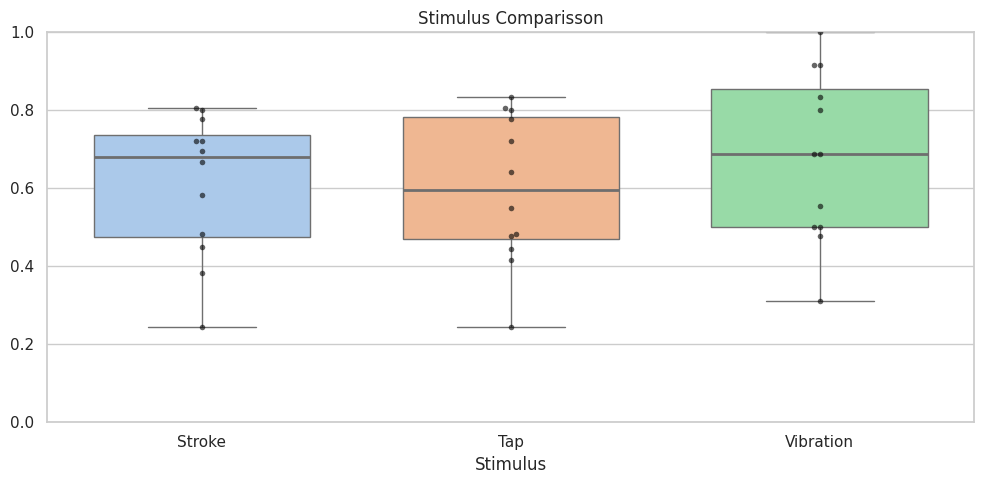

In [24]:
print_boxplots_and_tests_NEW(learnDataFrame, score="jaccard_coefficient", pdf_name="learn_data_averaged", plotting_order=["Tap", "Stroke", "Vibration"])

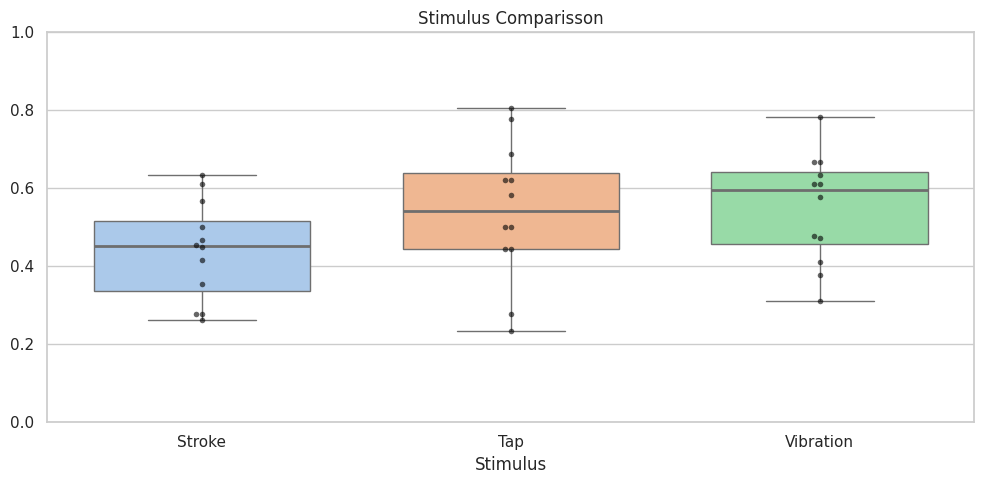

In [25]:
print_boxplots_and_tests_NEW(threeDimensionSet, score="jaccard_word_score", pdf_name="test_data_averaged", plotting_order=["Tap", "Stroke", "Vibration"])
